# Práctica análisis de redes sociales y algortimos genéticos y evolutivos. Amazon dataset
## Adrián Gayo e Iñaki del campo.

### Importamos las librerías necesarias

In [226]:
#!pip install python-louvain
#!pip install wurlitzer bayanpy infomap pyclustering ASLPAw
#!pip install pymoo
#!pip install deap
#!pip install optuna


In [227]:
import networkx as nx
import os
import matplotlib.pyplot as plt
from cdlib.algorithms import leiden
from sklearn.metrics import normalized_mutual_info_score
from sklearn import preprocessing
from collections import Counter
import pandas as pd
import numpy as np
import random
import math
import optuna
from pymoo.optimize import minimize
from deap import base, creator, tools, algorithms

## Estructura de comunidad con Leiden

### Cargamos el grafo desde archivo y lo visualizamos

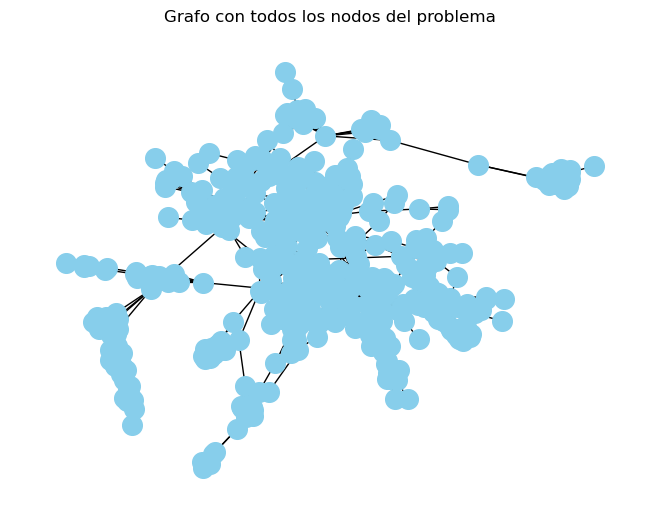

In [228]:

# Ruta donde se almacena el archivo que contiene el grafo.
archivo_graphml = 'amazon_graph/amazon_graph.graphml'

ruta_grafo =  os.path.abspath(archivo_graphml)

# Cargar el grafo desde el archivo GraphML
G = nx.read_graphml(ruta_grafo)

# Ahora visualizamos el contenido del grafo que hemos cargado.

pos = nx.spring_layout(G)  # Probar distintos layouts
nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=200, node_color='skyblue', font_size=8)
plt.title("Grafo con todos los nodos del problema")
# Mostrar el gráfico
plt.show()


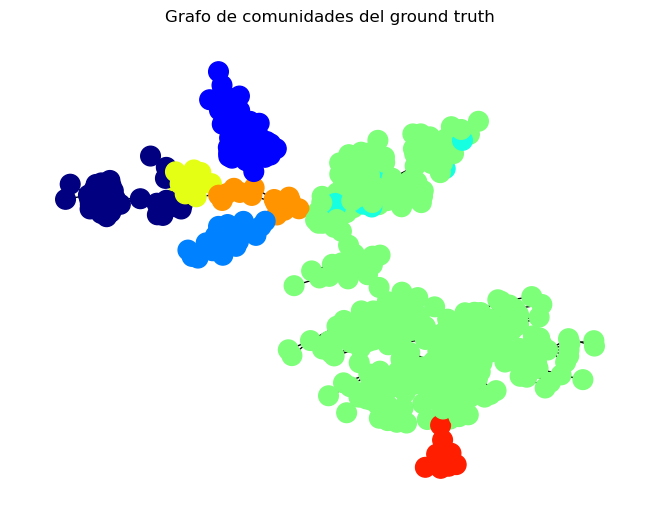

In [229]:
# Ahora lo visualizamos teniendo en cuenta las comunidades
comunidades_reales = nx.get_node_attributes(G, 'community')

# Crear un diccionario de colores para cada comunidad
colores_comunidades = {}
for comunidad in set(comunidades_reales.values()):
    colores_comunidades[comunidad] = plt.cm.jet(comunidad / len(set(comunidades_reales.values())))

# Asignar colores a los nodos según su comunidad
colores_nodos = [colores_comunidades[comunidades_reales[nodo]] for nodo in G.nodes]

# Probar distintos layouts
pos = nx.kamada_kawai_layout(G)

# Dibujar el grafo con colores de comunidades
nx.draw(G, pos, with_labels=False, node_size=200, node_color=colores_nodos, font_size=8)

plt.title("Grafo de comunidades del ground truth")

# Mostrar el gráfico
plt.show()

### Calculamos métricas del ground truth

In [230]:
# Calcula la densidad del grafo
density = nx.density(G)

# Obtenemos los datos originales de los nodos con la comunidad a la que pertenece en realidad.
lista_nodos = [(int(nodo), int(atributos['community'])) for nodo, atributos in G.nodes(data=True) if 'community' in atributos]

# Comprobamos la modularidad de la solución real.
partition_real = [set() for _ in range(max(comunidad for _, comunidad in lista_nodos) + 1)]
for nodo, comunidad in lista_nodos:
    partition_real[comunidad].add(str(nodo))

# Calcular la modularidad con la partición real
q_real = nx.community.modularity(G, partition_real)

print(f"Densidad del grafo: {density}")
print(f"\nModularidad con partición real: {q_real :.4f}")

Densidad del grafo: 0.010517432822562735

Modularidad con partición real: 0.5748


### Detectamos las comunidades con el algoritmo de Leiden

defaultdict(<class 'list'>, {'176159': [0], '401449': [0], '321619': [0], '432229': [0], '59613': [0], '430314': [0], '30962': [0], '35067': [0], '217346': [0], '295177': [0], '190765': [0], '198973': [0], '141635': [0], '258382': [0], '108892': [0], '475666': [0], '326211': [0], '504412': [0], '539292': [0], '109222': [0], '51902': [0], '150207': [0], '428737': [0], '447224': [0], '500473': [0], '365309': [0], '365354': [0], '295752': [0], '265066': [0], '285549': [0], '127928': [0], '310236': [0], '373756': [0], '211967': [0], '336905': [0], '19509': [0], '199759': [0], '74895': [0], '484561': [0], '392463': [0], '279830': [0], '423198': [0], '197919': [0], '230788': [0], '236947': [0], '46508': [0], '380338': [0], '112056': [0], '404948': [0], '179698': [0], '187924': [0], '310851': [0], '470620': [0], '452208': [0], '122517': [0], '313006': [0], '108259': [0], '268123': [0], '317367': [0], '221281': [1], '104553': [1], '383087': [1], '522378': [1], '309411': [1], '366824': [1], '20

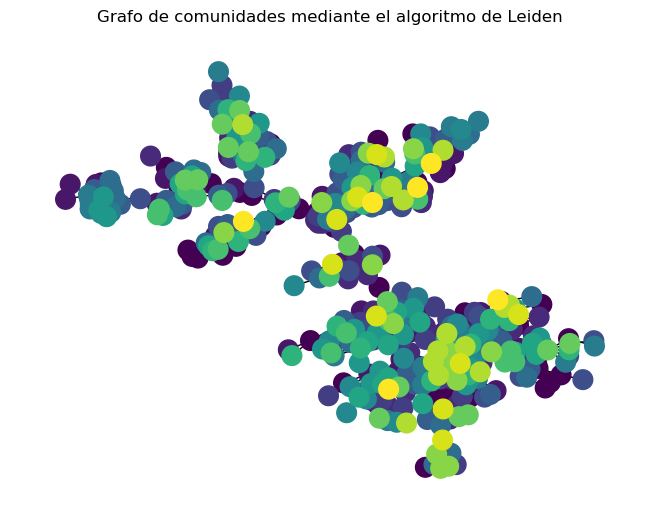

In [231]:
leiden_coms = leiden(G).to_node_community_map()
print(leiden_coms)

coms = {k:v[0] for k,v in leiden_coms.items()}

# Crear un diccionario que asigna colores únicos a cada comunidad
colores_comunidades = {comunidad: idx for idx, comunidad in enumerate(set(coms.values()))}

# Obtener colores para cada nodo según su comunidad
colores_nodos = [colores_comunidades[comunidad] for comunidad in coms.values()]

print(colores_nodos)

# Visualizar el grafo con las comunidades coloreadas
#pos = nx.spring_layout(G)
pos = nx.kamada_kawai_layout(G)  # Utilizamos kamada_kawai_layout para organizar los nodos de manera estructurada
nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=200, font_size=8, node_color=colores_nodos)

plt.title("Grafo de comunidades mediante el algoritmo de Leiden")
# Mostrar el gráfico
plt.show()

Probamos con diferentes formas de grafo

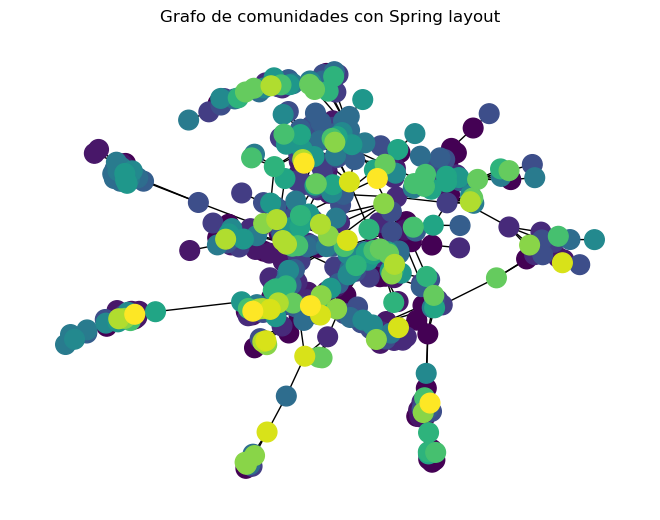

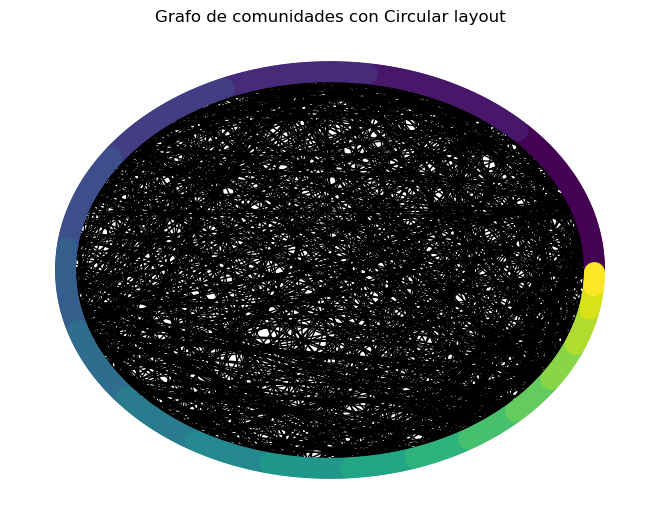

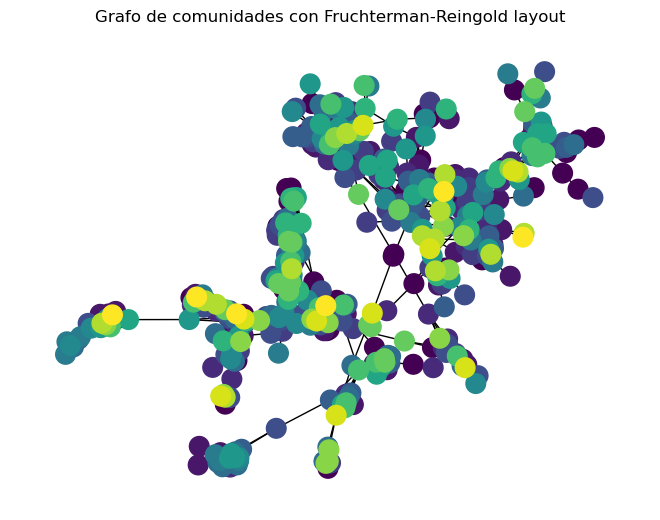

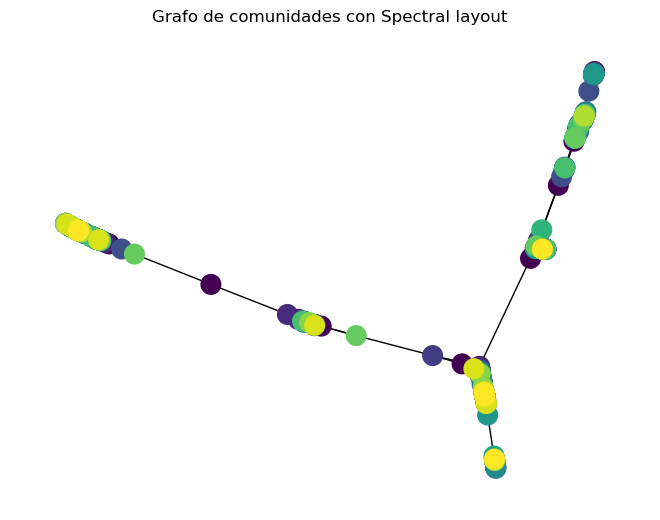

In [232]:
#Spring layout
pos = nx.spring_layout(G) 
nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=200, font_size=8, node_color=colores_nodos)
plt.title("Grafo de comunidades con Spring layout")
plt.show()

#Circular layout
pos = nx.circular_layout(G) 
nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=200, font_size=8, node_color=colores_nodos)
plt.title("Grafo de comunidades con Circular layout")
plt.show()

#Fruchterman-Reingold layout
pos = nx.fruchterman_reingold_layout(G) 
nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=200, font_size=8, node_color=colores_nodos)
plt.title("Grafo de comunidades con Fruchterman-Reingold layout")
plt.show()

#Spectral layout
pos = nx.spectral_layout(G) 
nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=200, font_size=8, node_color=colores_nodos)
plt.title("Grafo de comunidades con Spectral layout")
plt.show()

### Obtenemos la frecuencia de cada comunidad

In [233]:
#Contar la frecuencia de cada valor en el diccionario
frecuencia_coms = Counter(coms.values())

# Convertir el diccionario de frecuencias a un DataFrame de pandas
df_frecuencias = pd.DataFrame(frecuencia_coms.items(), columns=['Comunidad', 'Frecuencia'])

# Imprimir el DataFrame sin el índice
print(df_frecuencias.to_string(index=False))

 Comunidad  Frecuencia
         0          59
         1          49
         2          42
         3          42
         4          37
         5          32
         6          29
         7          26
         8          23
         9          23
        10          19
        11          17
        12          17
        13          16
        14          15
        15          14
        16           9
        17           6


### Calculamos la modularidad

In [234]:
print(coms)

# Convertir el diccionario coms en una lista de conjuntos
partition = [set() for _ in range(max(coms.values()) + 1)]
for nodo, comunidad_id in coms.items():
    partition[comunidad_id].add(nodo)
    
print(partition)
    
q =  nx.community.modularity(G, partition)

print(f"\nModularidad del algoritmo de Leiden: {q :.4f}")

{'176159': 0, '401449': 0, '321619': 0, '432229': 0, '59613': 0, '430314': 0, '30962': 0, '35067': 0, '217346': 0, '295177': 0, '190765': 0, '198973': 0, '141635': 0, '258382': 0, '108892': 0, '475666': 0, '326211': 0, '504412': 0, '539292': 0, '109222': 0, '51902': 0, '150207': 0, '428737': 0, '447224': 0, '500473': 0, '365309': 0, '365354': 0, '295752': 0, '265066': 0, '285549': 0, '127928': 0, '310236': 0, '373756': 0, '211967': 0, '336905': 0, '19509': 0, '199759': 0, '74895': 0, '484561': 0, '392463': 0, '279830': 0, '423198': 0, '197919': 0, '230788': 0, '236947': 0, '46508': 0, '380338': 0, '112056': 0, '404948': 0, '179698': 0, '187924': 0, '310851': 0, '470620': 0, '452208': 0, '122517': 0, '313006': 0, '108259': 0, '268123': 0, '317367': 0, '221281': 1, '104553': 1, '383087': 1, '522378': 1, '309411': 1, '366824': 1, '202986': 1, '127262': 1, '418177': 1, '504199': 1, '377247': 1, '416162': 1, '246180': 1, '502212': 1, '277024': 1, '299611': 1, '434830': 1, '512729': 1, '2178

### Calculamos el NMI

In [235]:
# Calcular el NMI
ground_truth_labels = list(comunidades_reales.values())
predicted_labels = list(coms.values())

# Normalizar las etiquetas para asegurar que tengan el mismo rango
ground_truth_labels = preprocessing.LabelEncoder().fit_transform(ground_truth_labels)
predicted_labels = preprocessing.LabelEncoder().fit_transform(predicted_labels)

nmi_score = normalized_mutual_info_score(ground_truth_labels, predicted_labels)

print(f"NMI Score: {nmi_score}")

NMI Score: 0.09033798458218277


### Comparamos los resultados obtenidos con los reales

In [236]:

# Ordenamos la lista para poder comparar las dos más fácilmente.
lista_nodos.sort() # No es necesario para fusionarlo, pero así generamos el df ordenado.

print("lista de nodos y comunidades:\n")
print(lista_nodos)

# Modificamos y ordenamos la lista de Leiden para que coincidan ambas listas.
lista_leiden = [(int(nodo), int(atributos[0])) for nodo, atributos in leiden_coms.items()] 
lista_leiden

# Crear DataFrames a partir de las listas
df_real = pd.DataFrame(lista_nodos, columns=['Nodo', 'Comunidad_Real'])
df_leiden = pd.DataFrame(lista_leiden, columns=['Nodo', 'Comunidad_Leiden'])

# Fusionar los DataFrames en función del índice (Nodo)
df_comunidades = pd.merge(df_real, df_leiden, on='Nodo')

df_comunidades


lista de nodos y comunidades:

[(278, 4), (2486, 4), (4328, 4), (5081, 0), (9526, 0), (9762, 2), (12959, 4), (14073, 1), (14076, 1), (14686, 4), (16457, 2), (16832, 0), (18041, 4), (18650, 7), (19509, 4), (19999, 4), (21786, 4), (27890, 6), (28513, 2), (29354, 4), (29586, 4), (30093, 4), (30398, 4), (30688, 4), (30690, 4), (30962, 4), (33191, 1), (33251, 4), (33710, 4), (34895, 3), (35067, 4), (35308, 4), (38265, 3), (38671, 4), (41336, 6), (42473, 4), (43379, 4), (44908, 1), (45362, 4), (45561, 4), (46508, 4), (48131, 6), (49424, 4), (51157, 4), (51175, 2), (51902, 4), (52064, 6), (52500, 4), (52511, 4), (52785, 4), (55386, 6), (55388, 6), (57383, 6), (57600, 1), (58975, 1), (58977, 1), (59285, 4), (59532, 4), (59613, 4), (59759, 4), (59912, 4), (60211, 4), (60627, 4), (64879, 4), (67016, 4), (67572, 4), (69337, 1), (70522, 4), (71187, 4), (72915, 0), (72916, 0), (74895, 4), (75780, 4), (77701, 4), (79870, 4), (80379, 4), (80756, 4), (81228, 1), (83510, 4), (83649, 1), (83906, 4), (84

,Nodo,Comunidad_Real,Comunidad_Leiden
0,278,4,4
1,2486,4,10
2,4328,4,6
3,5081,0,9
4,9526,0,9
...,...,...,...
470,544939,2,14
471,545994,5,7
472,545995,5,7
473,546890,5,7


In [237]:
# Generamos una nueva columna que indique si el valor de ambas comunidades coincide.
df_comunidades['Coinciden'] = np.where(df_comunidades['Comunidad_Real'] == df_comunidades['Comunidad_Leiden'], True, False)

df_comunidades

,Nodo,Comunidad_Real,Comunidad_Leiden,Coinciden
0,278,4,4,True
1,2486,4,10,False
2,4328,4,6,False
3,5081,0,9,False
4,9526,0,9,False
...,...,...,...,...
470,544939,2,14,False
471,545994,5,7,False
472,545995,5,7,False
473,546890,5,7,False


In [238]:
acierto = sum(df_comunidades['Coinciden']) / len(df_comunidades)  #Esto no tiene sentido porque no tienen porque tener la misma etiqueta.

acierto

0.07789473684210527

## Algoritmo Evolutivo multiobjetivo

### Codificamos el grafo
Crearemos los objetos que serán necesarios más adelante para trabajar en el proceso evolutivo. Tenemos que generar las listas mapeadas con el id del nodo sustituido por la posición que tomará en el vector de individuos. Es importante generar una con el nodo incluido y otra sin ella. Así como objetos que permitan volver luego al estado original.

In [239]:
# Obtiene la lista de adyacencia
adjacency_list = nx.to_dict_of_lists(G)

N = len(adjacency_list) # Número de nodos que tiene el grafo
print(f"Número de Nodos: {N}")

print("\nLista de Adyacencia:")
print(adjacency_list)

# Añadimos el propio nodo a la lista de vecinos.
for nodo, lista in adjacency_list.items():
    lista.append(nodo)

print("\nLista de Adyacencia con el nodo incluido:")
print(adjacency_list)
    
# Obtenemos el orden de los nodos en el grafo
node_order = list(G.nodes()) # No es necesario hacer un set, porque recibimos todos los nodos sin repeticiones.

# Crea un diccionario que mapea nodos a sus posiciones en el vector
mapeo_nodos = {nodo: indice for indice, nodo in enumerate(node_order)} # Puede que haya que crear también uno para decodificar.

# Mapea la lista de adyacencia a las posiciones en el vector
lista_adyacencia_mapeada = {mapeo_nodos[nodo]: [mapeo_nodos[adyacente] for adyacente in adyacentes] for nodo, adyacentes in adjacency_list.items()}

# Mapea la lista de adyacencia sin el propio nodo
lista_adyacencia_mapeada_sin_nodo = {mapeo_nodos[nodo]: [mapeo_nodos[adyacente] for adyacente in adyacentes if adyacente != nodo] for nodo, adyacentes in adjacency_list.items() if nodo in mapeo_nodos}

# Generamos de nuevo el grafo con los valores de los nodos mapeados.
G_normalizado = nx.Graph(lista_adyacencia_mapeada_sin_nodo) 

# Muestra el resultado
print("\nMapeo de Nodos a Posiciones en el Vector:")
print(mapeo_nodos)
print("\nLista de Adyacencia Mapeada:")
print(lista_adyacencia_mapeada)
print("\nLista de Adyacencia Mapeada sin incluir el nodo:")
print(lista_adyacencia_mapeada_sin_nodo)

# Para decodificar, invierte el diccionario de mapeo
mapeo_nodos_inverso = {indice: nodo for nodo, indice in mapeo_nodos.items()}
print("\nMapeo Inverso de Posiciones en el Vector a Nodos Originales:")
print(mapeo_nodos_inverso)
    


Número de Nodos: 475

Lista de Adyacencia:
{'75780': ['182923', '423864', '458993'], '317458': ['480479', '500861', '500865'], '186386': ['299055', '394703', '414657', '521655'], '419862': ['33251', '98081', '152407', '458993', '496201'], '176159': ['19509', '30962', '190765', '230788', '373756', '404948', '428737'], '204831': ['28513', '159972', '189286', '313801', '342330', '379184'], '104481': ['394886'], '57383': ['27890', '165463', '219781', '238491', '335987', '389895', '458993', '483076', '538129'], '401449': ['187924', '198973', '470620'], '299055': ['186386', '154202'], '176184': ['256445'], '542780': ['9762', '16457', '214555', '542319', '542899'], '366654': ['83906', '123953'], '124992': ['49424', '123681', '460073'], '16457': ['542780', '9762', '126438', '196682', '216152', '542319'], '196682': ['16457', '9762', '126438', '216152', '542319', '542899'], '546890': ['109595', '114378', '114379', '123181', '126430', '126433', '132756', '132763', '246060', '270524', '546891'], '

In [240]:
def decodificar_grafo(vector): 
    """
    Función que convierte la lista de adyacencia a grafo.
    """ 
    # Decodificamos el vecctor a una lista de adyacencia
    locus_adjacency = {i : [vecino] for i, vecino in enumerate(vector, 0)}
    
    # Crea un nuevo grafo a partir de la lista de adyacencia
    decoded_graph = nx.Graph(locus_adjacency)

    return decoded_graph


In [241]:
# Declaramos globalmente los nombres de las funciones objetivo.
objetivo1 = "Internal Density"
objetivo2 = "community Score"

### Representaciones
Declaramos funciones cuyo objetivo es representar gráficamente la evolución de nuestra población, grafos, etc.

In [242]:
def representa_grafos_del_frente(individuals):
    """
    Visualiza los grafos decodificados a partir de una lista de individuos.

    Parameters:
    - individuals: Lista de individuos, donde cada individuo representa un grafo.

    Returns:
    - None (muestra el grid de gráficos)
    """

    #Determina el tamaño del grid basado en la cantidad de individuos
    num_individuals = len(individuals)
    num_cols = math.ceil(math.sqrt(num_individuals))  # Configura el número de columnas basado en la raíz cuadrada
    num_rows = math.ceil(num_individuals / num_cols)  # Redondeo hacia arriba

    # Configura el grid de subgráficos
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    # Ravel convierte el array multidimensional en uno unidimensional
    axs = axs.ravel()

    for i in range(num_individuals):
        # Decodifica el individuo para obtener el grafo
        decoded_graph = decodificar_grafo(individuals[i])

        # Calcula las componentes conexas
        components = list(nx.connected_components(decoded_graph))

        # Asigna un color aleatorio a cada componente
        color_map = {}
        for j, component in enumerate(components):
            color_map.update({node: j for node in component})

        # Dibuja el grafo con colores asignados a las componentes conexas
        axs[i].set_title(f'Grafo {i+1}')
        pos = nx.spring_layout(G_normalizado)
        node_colors = [color_map[node] for node in decoded_graph.nodes()]
        nx.draw(decoded_graph, pos, with_labels=False, font_weight='bold', node_size=200, node_color=node_colors, cmap=plt.cm.rainbow, edge_color='black', ax=axs[i])
        # Añade texto con el número de comunidades
        axs[i].text(0.5, -0.1, f'Comunidades: {len(components)}', size=12, ha="center", transform=axs[i].transAxes)

    # Ajusta el diseño y muestra el grid de gráficos
    plt.tight_layout()
    plt.show()
    
    
    
def representa_frente_pareto(individuals):
    """
    Visualiza el frente de Pareto a partir de los valores de fitness de los individuos.

    Parameters:
    - individuals: Lista de individuos, donde cada individuo tiene valores de fitness.

    Returns:
    - None (muestra el gráfico)
    """

    # Extraer valores de los objetivos desde los individuos
    obj1 = [ind.fitness.values[0] for ind in individuals]
    obj2 = [ind.fitness.values[1] for ind in individuals]

    # Crear un gráfico de dispersión para el frente de Pareto
    plt.scatter(obj1, obj2, label='Individuo del frente', color='blue')

    # Configurar etiquetas con las variables del nombre de cada objetivo y título del gráfico
    plt.xlabel(f"Objetivo 1: {objetivo1}")
    plt.ylabel(f"Objetivo 2: {objetivo2}")
    plt.title('Frente de Pareto')
    
    # Mostrar la leyenda
    plt.legend()
    
    # Mostrar el gráfico
    plt.show()


### Funciones Objetivo

En el artículo *SHI, Chuan, et al. Comparison and selection of objective functions in multiobjective community detection. Computational Intelligence, 2014, vol. 30, no 3, p. 562-582.* nos propone una serie de funciones objetivo dentro de la detección de comunidades. La conclusión importante que nos proporciona el texto es que da mejores resultados utilizar funciones objetivo que estén negativamente correlacionadas. Esto significa que, si aumenta el valor de una de ellas, la otra tiende a disminuir su valor. 

Las tres funciones que vamos a implementar y el motivo por el que se utilizan son las siguientes: 

**Internal Density:** Se busca maximizar la densidad interna de las comunidades, ya que esto indicará que las conexiones dentro de las comunidades son más fuertes.

**Community Score:** Se busca maximizar el Community Score, ya que esto indica que las conexiones entre las comunidades son más débiles en comparación con las conexiones internas.

**Modularidad (Q):** La modularidad también se busca maximizar, ya que valores más altos indican una partición de comunidades más fuerte y más significativa.

En particular, las dos opciones que tenemos para la optimización multiobjetivo son: {Q, Internal Density} y {Community Score, Internal Density}

In [243]:
def internal_density(graph, communities):
    """
    Calcula la densidad interna de un clúster en un grafo.

    Parameters:
    - graph: Grafo (objeto NetworkX)
    - communities: Lista de nodos que forman las comunidades

    Returns:
    - Densidad interna del grafo
    """

    sum_internal_density = 0

    for community in communities:
        num_nodes_cluster = len(community) # Número de nodos que forman la comunidad
        if num_nodes_cluster <= 1: # Asegurarse de no dividir por cero, penalizamos comunidades de un solo elemento.
            continue
        cluster_subgraph = graph.subgraph(community) # Subgrafo formado por los nodos de la comunidad actual
        num_internal_edges = cluster_subgraph.number_of_edges() # Número de aristas internas en la comunidad actual   
           
        # Añadimos el valor de la comunidad al sumatorio.
        sum_internal_density += 1 - (num_internal_edges / (num_nodes_cluster * (num_nodes_cluster - 1) / 2)) 
    
    return sum_internal_density / len(communities) # Devolvemos el valor normalizado


def community_score(graph, communities):
    """
    Calcula el Community Score de un clúster en un grafo.

    Parameters:
    - graph: Grafo (objeto NetworkX)
    - communities: Lista de nodos que forman el clúster

    Returns:
    - Community Score del clúster
    """

    sum_community_score = 0

    for community in communities:

        num_nodes_cluster = len(community) # Número de nodos en la comunidad actual
        if num_nodes_cluster <= 1: # Asegurarse de no dividir por cero, penalizamos comunidades de un solo elemento.
            continue
        # Número total de aristas externas conectadas a la comunidad actual.
        num_external_edges = sum(graph.degree(node) - graph.subgraph([node]).number_of_edges() for node in community)
        sum_community_score += (2 * num_external_edges / num_nodes_cluster) ** 2

    avg_community_score = sum_community_score / len(communities) # Devolvemos el valor 
    return 1 / max(avg_community_score, 0.0001) # Devolvemos el valor normalizado para minimizarlo entre 0 y 1. También aseguramos que no hay división por 0.


def modularity(graph, communities):
    """
    Calcula la modularidad (Q) de una partición en un grafo.

    Parameters:
    - graph: Grafo (objeto NetworkX)
    - communities: Lista de conjuntos de nodos que forman la partición

    Returns:
    - Valor de modularidad (Q) del grafo.
    """

    modularity_value =  nx.community.modularity(graph, communities)
    return modularity_value


def numero_de_comunidades(graph, communities):
    """
    Función extra que no sigue el criterio de mencionado en el artículo.
    Se busca minimizar el número de comunidades generadas.

    Parameters:
    - graph: Grafo (objeto NetworkX)
    - communities: Lista de conjuntos de nodos que forman la partición

    Returns:
    - Valor normalizado del número de comunidades..
    """
    num_com = len(communities)
    return num_com / N # Devolvemos un valor normalizado sobre todas las comunidades posibles.


### Métodos Evolutivos
En esta sección declararemos los métodos encargados de realizar las operaciones evolutivas. Debemos inicializar una población "aleatoria" a partir del grafo codificado que hemos generado. También tenemos que implementar las operaciones de cruce, mutación y selección.

In [244]:
def inicializar_poblacion(lista_adyacencia, tam_poblacion, tam_individuo):
    """
    Inicializa una población para el algoritmo evolutivo.

    Parameters:
    - lista_adyacencia_mapeada: Lista de adyacencia mapeada.
    - tam_poblacion: Tamaño de la población.
    - tam_individuo: Tamaño de cada individuo.
    

    Returns:
    - Población inicializada.
    """
    nodos = list(lista_adyacencia.keys())
    poblacion = []

    for _ in range(tam_poblacion):
        individuo = [random.choice(lista_adyacencia_mapeada[nodo]) for nodo in nodos]
        poblacion.append(individuo)

    return poblacion


def cruce(padre1, padre2, probabilidad_cruce=0.7):
    """
    Realiza el cruce de dos individuos utilizando una máscara aleatoria en función de una probabilidad de cruce.

    Parameters:
    - padre1: Primer individuo.
    - padre2: Segundo individuo.
    - probabilidad_cruce: Probabilidad de cruce.

    Returns:
    - Individuos descendientes generado por cruce.
    """
    padre1_copia = padre1.copy()
    padre2_copia = padre2.copy()
    # Verifica si se produce el cruce según la probabilidad. En caso contrario se devuleven los propios padres.
    if random.random() > probabilidad_cruce:
        return padre1_copia, padre2_copia
    
    # Genera una máscara aleatoria binaria del tamaño de los individuos
    mascara = [random.choice([0, 1]) for _ in range(len(padre1))]

    # Combina los elementos de los padres según la máscara
    hijo1 = [padre1_copia[i] if mascara[i] == 0 else padre2_copia[i] for i in range(len(padre1_copia))]
    hijo2 = [padre2_copia[i] if mascara[i] == 0 else padre1_copia[i] for i in range(len(padre1_copia))] 

    return hijo1, hijo2


def mutacion(individuo, lista_adyacencia_mapeada, probabilidad_mutacion=0.1):
    """
    Realiza la mutación en un individuo. La mutación consiste en elegir otro nodo adyacente aleatorio.
    Se utiliza la lista de adyacencia para poder generar individuos válidos.

    Parameters:
    - individuo: Individuo a mutar.
    - probabilidad_mutacion: Probabilidad de mutación para cada gen.
    - lista_adyacencia_mapeada: Lista de adyacencia mapeada.

    Returns:
    - Individuo mutado.
    """
    individuo_copia = individuo.copy()
    for i in range(len(individuo_copia)):
        if random.random() < probabilidad_mutacion:
            # Sustituye el valor del gen por uno aleatorio de la lista de adyacencia mapeada
            individuo_copia[i] = random.choice(lista_adyacencia_mapeada[i])

    return individuo_copia


def torneo(individuos, k, fitness=0, tournsize=3):
    """
    Realiza el proceso de selección por torneo para elegir individuos de una población.

    Parameters:
    - individuos: Lista de individuos a partir de los cuales realizar la selección.
    - k: Número de individuos a seleccionar.
    - fitness: Lista de valores de aptitud asociados a los individuos (por defecto, 0 si no se proporciona).
    - tournsize: Tamaño del torneo, es decir, cuántos individuos se seleccionan al azar en cada torneo.

    Returns:
    - Lista de individuos seleccionados mediante el método de torneo.
    """
    ganadores = []
    
    for _ in range(k):
        # Selecciona tournsize individuos al azar
        participants = random.sample(individuos, tournsize)
             
        # Decidimos el ganador en base a un criterio de no dominancia.
        pareto_front = tools.sortNondominated(participants, len(participants), first_front_only=True)
        ganadores.append(pareto_front[0][0])
    
    return ganadores


In [245]:
# Ejemplo de uso:
poblacion_inicial = inicializar_poblacion(lista_adyacencia_mapeada, N, 50)
hijo1, hijo2 = cruce(poblacion_inicial[0], poblacion_inicial[1], 0.75)
individuo_mutado = mutacion(poblacion_inicial[5], lista_adyacencia_mapeada, 0.2)

### Ciclo Evolutivo

Vamos a utilizar la librería pymoo donde están implementados la mayoría de algoritmos de optimización multiobjetivo. Para ello, debemos adaptar nuestro problema a la interfaz que utiliza la librería.

In [246]:
# Declaramos el nombre de los objetivos más arriba.

def evaluacion_individuos(indiviudos):
    """
    Evalúa una población de individuos en base a la función objetivo seleccionada. Cada individuo codifica un grafo representado con Locus.

    Parameters:
    - indiviudos: Lista de individuos codificados, cada uno representando un grafo.

    Returns:
    - Lista de tuplas, donde cada tupla contiene los valores de los objetivos elegidos asociados a un grafo en la población evaluada.
    """
    graphs = [decodificar_grafo(ind) for ind in indiviudos]
    conjuntos_poblacion = [list(nx.connected_components(g)) for g in graphs]
    comunidades_individuos = [[list(conjunto) for conjunto in conjuntos_individuo] for conjuntos_individuo in conjuntos_poblacion]
    # Obtenemos las comunidades con la codificación locus y evaluamos el grafo real (G)
    fitness_values = [(internal_density(G_normalizado, comunidades), community_score(G_normalizado, comunidades)) for comunidades in comunidades_individuos]
    return fitness_values

#### Parámetros del algoritmo

In [253]:
population_size = 100
generaciones = 500
pmut=0.1
pcross=0.7
punto_referencia = [1.0, 1.0]  # Punto de referencia para el frente de pareto.

#### Implementación del hipervolumen

In [248]:
def calculate_hypervolume(frente, reference_point):
    """
    Calcula el hipervolumen para un conjunto de puntos en el espacio objetivo.

    Parameters:
    - frente: Lista de individuos en el frente de pareto con su fitness en cada objetivo.
    - reference_point: Punto de referencia en el espacio objetivo (lista de coordenadas).

    Returns:
    - Valor del hipervolumen.
    """
    #sorted_individuals = sorted(frente, key=lambda ind: ind.fitness.values[0], reverse=True)  # Ordenar individuos por el primer objetivo en orden descendente

    hypervolume = 0.0

    for ind in frente:
        hypervolume += abs(reference_point[0] - ind.fitness.values[0]) * abs(reference_point[1] - ind.fitness.values[1])

    return hypervolume / len(frente) # Normalizamos el valor para que no influya el número de puntos.

#### NSGA-II

In [249]:
# Configuramos las variables de DEAP
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

In [250]:
def nsga2_select(individuals, k, ndim=2, domination_criterion=tools.sortNondominated):
    # Asignar valores de aptitud a los individuos si no están presentes
    individuals_with_fitness = []
    for ind, fitness_values in individuals:
        if not hasattr(fitness_values, 'fitness'):
            fitness = creator.FitnessMulti(values=fitness_values)
            ind = creator.Individual(ind)
            ind.fitness = fitness
            individuals_with_fitness.append(ind)
            
    # Selección SPEA2
    selected = tools.selNSGA2(individuals_with_fitness, k)
    # Ordenar los individuos según la dominancia de Pareto
    front = domination_criterion(individuals_with_fitness, k, first_front_only=True)

    return selected, front[0] #Devolvemos la población dominante y el frente de pareto.


#### SPEA2

In [251]:
# Modificar la función de selección para utilizar SPEA2
def spea2_select(individuals, k, ndim=2):
    # Asignar valores de aptitud a los individuos si no están presentes
    individuals_with_fitness = []
    for ind, fitness_values in individuals:
        if not hasattr(fitness_values, 'fitness'):
            fitness = creator.FitnessMulti(values=fitness_values)
            ind = creator.Individual(ind)
            ind.fitness = fitness
            individuals_with_fitness.append(ind)

    # Selección SPEA2
    selected = tools.selSPEA2(individuals_with_fitness, k)

     # Obtener el frente de Pareto de los individuos seleccionados
    pareto_front = tools.sortNondominated(selected, k, first_front_only=True)

    return selected, pareto_front[0]

### Parte principal del ciclo evolutivo


Generación 0


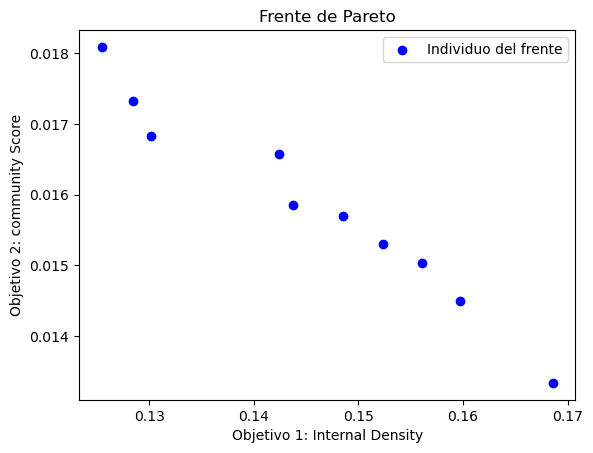

Hipervolumen: 0.8408786938273984

Generación 20


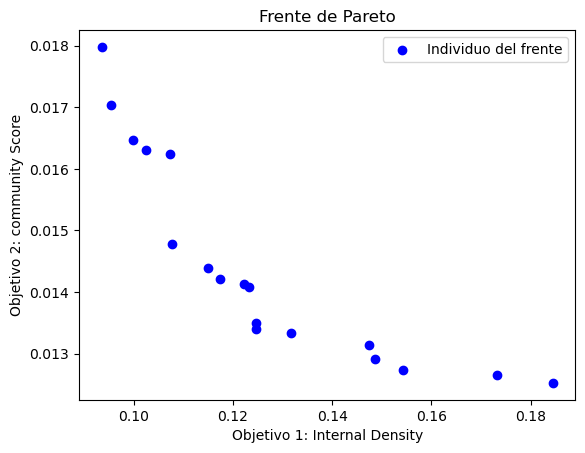

Hipervolumen: 0.8610720202655794

Generación 40


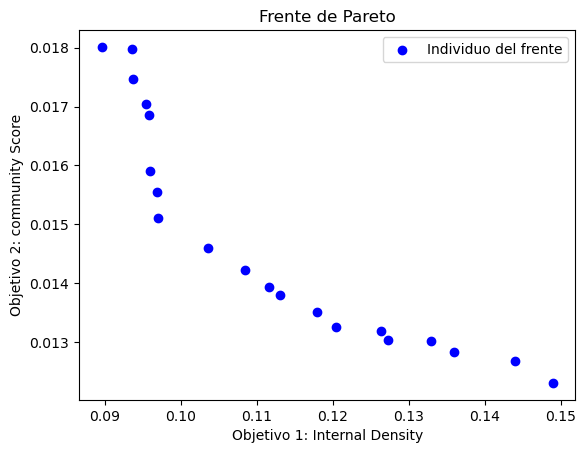

Hipervolumen: 0.8745078559827892


KeyboardInterrupt: 

In [254]:
# Población inicial
population = inicializar_poblacion(lista_adyacencia_mapeada, population_size, N)

# Bucle evolutivo
for gen in range(generaciones):
    
    new_pop = []
       
    # Realizar operaciones de cruce y mutación según tus necesidades
    while len(new_pop) < population_size:
        if gen < 1:
            parents = random.sample(population, 2) # Elección aleatoria la primera vez.
        else:
            parents = torneo(population, 2) #selección por torneo
            
        child1, child2 = cruce(parents[0], parents[1], pcross)
        child1 = mutacion(child1, lista_adyacencia_mapeada, pmut)
        child2 = mutacion(child2, lista_adyacencia_mapeada, pmut)
        new_pop.extend([child1, child2])

    population.extend(new_pop)
    
    fitness = evaluacion_individuos(indiviudos=population)
    population_with_fitness = list(zip(population, fitness))

    # Seleccionar individuos utilizando NSGA-II
    new_pop, frente_pareto = nsga2_select(population_with_fitness, k=population_size)

    # Sustituir la población anterior con los nuevos individuos
    population = new_pop
    
    # Imprimimos una traza de la evolución con el hipervolumen
    if gen % 20 == 0: 
        print(f"\nGeneración {gen}")
        #Representa el frente de pareto.
        representa_frente_pareto(frente_pareto)
        # Calcula el hipervolumen
        #hv_value = tools.hypervolume(frente_pareto)
        hv_value = calculate_hypervolume(frente=frente_pareto, reference_point=punto_referencia)
        print(f"Hipervolumen: {hv_value}")

# Obtener el frente de Pareto final
print("Frente de pareto final:")
representa_frente_pareto(frente_pareto)
print("Grafos del pareto final:")
representa_grafos_del_frente(frente_pareto)


## Análisis de las soluciones del Pareto
